In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.family']='DFKai-SB' #顯示中文 (for Win10)
plt.rcParams['axes.unicode_minus']=False #正常顯示負號

pd.set_option("display.max_columns",50) #設定pandas最多顯示出50個欄位資訊

df = pd.read_csv('A_LVR_LAND_A.csv', encoding='big5') #台北市

In [3]:
# 去除土地和車位兩種交易資料
df = df[(df['交易標的']!='土地') & (df['交易標的']!='車位')].reset_index(drop=True)
#改成以萬為單位，方便圖表顯示
df.loc[:,'總價元'] = df.loc[:,'總價元']/10000 
for i in range(len(df)):
    df.loc[i,'交易年'] = round(df.loc[i,'交易年月日']/10000)
from datetime import datetime
now = datetime.now()
now.year #(年,月,日,時,分,秒,微秒) ps: 微秒(microseconds)=1/1000000秒
for i in range(len(df)):
    df.loc[i,'建築完成年'] = round(df.loc[i,'建築完成年月']/10000)
    df.loc[i,'屋齡'] = now.year - 1911 - round(df.loc[i,'建築完成年月']/10000)
#df.sample(5)

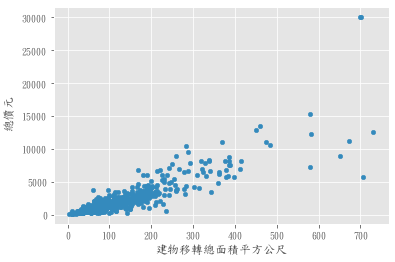

In [4]:
df = df[['鄉鎮市區','土地移轉總面積平方公尺','建物移轉總面積平方公尺','單價每平方公尺','建物現況格局-房','建物現況格局-廳','建物現況格局-衛','車位移轉總面積平方公尺','車位總價元','屋齡','建築完成年','交易年','總價元']]
df_ml = df.dropna().reset_index(drop=True)

df_ml = df_ml[df_ml['建物移轉總面積平方公尺']<1000]
df_ml.plot(kind='scatter',x='建物移轉總面積平方公尺',y='總價元')
#df_ml.sample(2)

### 拆分資料集(features)

In [5]:
from sklearn.model_selection import train_test_split

X = df_ml[['建物移轉總面積平方公尺','屋齡']]
y = df_ml[['總價元']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) # 30% for testing, 70% for training
X_train.head()

,建物移轉總面積平方公尺,屋齡
485,96.77,33.0
265,80.39,19.0
361,123.87,20.0
317,102.63,3.0
280,260.33,3.0


### 標準化

In [6]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
#Compute the mean and std to be used for later scaling.
sc.fit(X_train)
#Perform standardization by centering and scaling
X_train_normalized = sc.transform(X_train)
X_test_normalized = sc.transform(X_test)

#SGDRegressor的input y需要一維矩陣type
y_train_1d = y_train.values.ravel()
y_test_1d = y_test.values.ravel()


In [7]:
print(type(X_train_normalized))
print(X_train_normalized[:5])
print(type(y_train_1d))
print(y_train_1d[:5])

<class 'numpy.ndarray'>
[[-0.30074795  0.555162  ]
 [-0.46743935 -0.37559877]
 [-0.02496427 -0.30911586]
 [-0.24111355 -1.43932537]
 [ 1.36372359 -1.43932537]]
<class 'numpy.ndarray'>
[2528. 1160. 1860. 1350. 8988.]


### 訓練模型

In [8]:
from sklearn import datasets, linear_model


#linear regression 物件
#learning_rate='constant'學習速度維持常數
#max_iter學習步數
#eta0學習速率
sgdr = linear_model.SGDRegressor(max_iter=10,learning_rate='constant',eta0=0.001)

# 訓練模型
sgdr.fit(X_train_normalized, y_train_1d)

print('各變項參數:', sgdr.coef_)
#y_test_1d:實際y的資料
print("MSE: %.2f" % np.mean((sgdr.predict(X_test_normalized) - y_test_1d) ** 2))
#R Square計算
print("R Square:",sgdr.score(X_test_normalized,y_test))


各變項參數: [1757.61017962 -274.02695619]
MSE: 4044582.50
R Square: 0.6696076088678415


C:\Users\jas72\Anaconda3\envs\DarrenAI\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


### 實際測試

In [9]:
sgdr.predict(sc.transform(pd.DataFrame([[100,10],[200,20],[300,30]])))

array([1959.62468237, 3566.07902005, 5172.53335772])

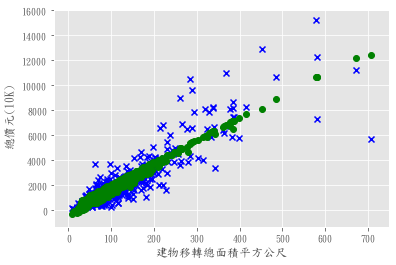

In [10]:
#訓練資料使用散步圖標示
plt.scatter(X_train['建物移轉總面積平方公尺'], y_train_1d,  color='blue', marker = 'x')
#預測直線使用線圖表示
plt.scatter((X_train['建物移轉總面積平方公尺']), sgdr.predict(X_train_normalized), color='green', linewidth=1)

plt.ylabel('總價元(10K)')
plt.xlabel('建物移轉總面積平方公尺')

plt.show()

Text(0.5, 0, '屋齡')

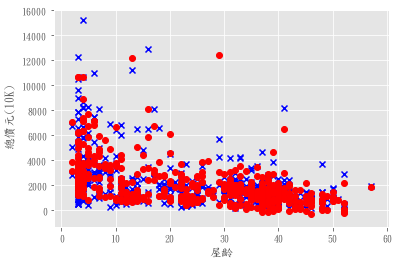

In [11]:
#訓練資料使用散步圖標示
plt.scatter(X_train['屋齡'], y_train_1d,  color='blue', marker = 'x')
#預測直線使用線圖表示
plt.scatter((X_train['屋齡']), sgdr.predict(X_train_normalized), color='red', linewidth=1)

plt.ylabel('總價元(10K)')
plt.xlabel('屋齡')


### K折交叉驗證 (K-fold Cross-Validation) + 學習曲線 (Learning Curve)

In [12]:
# Scikit-Learn 官網作圖函式
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize=(10,6))  #調整作圖大小
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Automatically created module for IPython interactive environment


<module 'matplotlib.pyplot' from 'C:\\Users\\jas72\\Anaconda3\\envs\\DarrenAI\\lib\\site-packages\\matplotlib\\pyplot.py'>

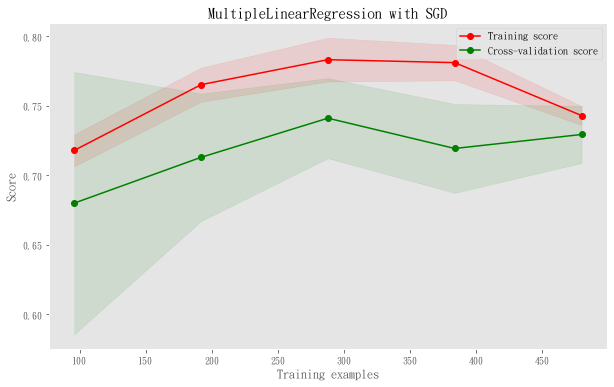

In [14]:
from sklearn.model_selection import KFold,StratifiedKFold
cv = KFold(n_splits=4, random_state=None, shuffle=True)
estimator = linear_model.SGDRegressor(max_iter=1000,learning_rate='constant',eta0=0.01)

plot_learning_curve(estimator, "MultipleLinearRegression with SGD", sc.transform(X), y.values.ravel(), cv=cv , train_sizes=np.linspace(0.2, 1.0, 5))